# REFER https://medium.com/web-mining-is688-spring-2021/customer-segmentation-using-k-means-clustering-33b210e0a2bb

# Loading Libraries And DataSet

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

In [2]:
# Reading the CSV file
df1 = pd.read_csv('Mall_Customers.csv')

In [3]:
df1

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
# Viewing a set of random sample from the DataFrame
df1.sample(6, random_state=12601996)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
36,37,Female,42,34,17
21,22,Male,25,24,73
178,179,Male,59,93,14
141,142,Male,32,75,93
57,58,Male,69,44,46
107,108,Male,54,63,46


# Data Pre Processing

In [5]:
# As CustomerID is an Unimportant Field for our purpouses, we will be dropping it
df1.drop(axis=1,labels="CustomerID",inplace=True)

In [6]:
# We Check for Missing Values
df1.isna().sum()[df1.isna().sum()!=0]

Series([], dtype: int64)

It can be seen there are **No** Missing Values

In [7]:
# We perform a quick Statistical Analysis on the columns
df1.describe(include='all')

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200.000000,200.000000,200.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,112,NaN,NaN,NaN
mean,NaN,38.850000,60.560000,50.200000
std,NaN,13.969007,26.264721,25.823522
min,NaN,18.000000,15.000000,1.000000
25%,NaN,28.750000,41.500000,34.750000
50%,NaN,36.000000,61.500000,50.000000
75%,NaN,49.000000,78.000000,73.000000


It can be seen from the *Gender* Column, that majority of the shoppers are Females (112 Feamles and 88 Males). The Mean *Age* is 38 and the Mode is 32. The Mean *Anuual Income* is $60,000 and the mode is $42,000. The Mean *Spending Score* is 50 and the mode is 42.


In [8]:
# Checking for Outliers using IQR
for i in df1.drop(columns='Gender').columns:
    q1 = df1[i].quantile(.25)
    q3 = df1[i].quantile(.75)
    iqr = q3-q1
    ul = q1 + 1.5*(iqr)
    ll = q1 - 1.5*(iqr)
    df_otlu = df1[i].loc[(df1[i]>ul)]
    df_otll = df1[i].loc[(df1[i]<ll)]
    verdict_o = 'Outliers Present' if (
        ul < max(df1[i]) or ll > min(df1[i])) else "No Outliers Present"
    print('For the column', i, 'There are', verdict_o)
    print('For the column', i, 'There are', len(df_otlu) + len(df_otll),'outlier records')


For the column Age There are Outliers Present
For the column Age There are 20 outlier records
For the column Annual Income (k$) There are Outliers Present
For the column Annual Income (k$) There are 20 outlier records
For the column Spending Score (1-100) There are Outliers Present
For the column Spending Score (1-100) There are 9 outlier records


Since There are only **200** records, we will see whether to remove these records as they are almost 10% of the data set.

# K Means Clustering for Customer Segmentation

In [9]:
enc = OneHotEncoder(handle_unknown='ignore',drop='first')

In [10]:
enc_df = pd.DataFrame(enc.fit_transform(df1[['Gender']]).toarray(),columns=['Gender'])

In [11]:
enc_df.columns

Index(['Gender'], dtype='object')

In [12]:
enc_df

,Gender
0,1.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
195,0.0
196,0.0
197,1.0
198,1.0


In [13]:
df1.drop(columns='Gender',inplace=True)

In [14]:
df1 = df1.join(enc_df)

In [15]:
df1.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')

In [16]:
df1

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,19,15,39,1.0
1,21,15,81,1.0
2,20,16,6,0.0
3,23,16,77,0.0
4,31,17,40,0.0
...,...,...,...,...
195,35,120,79,0.0
196,45,126,28,0.0
197,32,126,74,1.0
198,32,137,18,1.0


In [17]:
def optimized_n_cluster_value(df,range_min=2,range_max=10,random_state=12601996):
    """Get the optimized n_cluster value for use in KMeans
       Parameters-
       df : DataFrame
       range_min : n_cluster value to start at. Default=1
       range_max : n_cluster value to end at. Default=10
       random_state : The random_state value. Default=3
       Returns-
       Plot of No. of Clusters vs SSD and Plot of No. of Clusters vs Silhouette Score
       From these plots We can infer n_cluster value """
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    ssd=[]
    sscore=[]
    for k in range(range_min,range_max):
        kmeans= KMeans(n_clusters=k,random_state=random_state)
        kmeans.fit(df)
        ssd.append(kmeans.inertia_)
        ss=silhouette_score(df,kmeans.labels_)
        sscore.append(ss)
    plt.plot(range(range_min,range_max),ssd,'r-') 
    plt.xlabel('No. of Clusters')
    plt.ylabel('SSD')
    plt.title('Graph of No. of Clusters vs SSD')
    plt.show()
    plt.plot(range(range_min,range_max),sscore,'r-') 
    plt.xlabel('No. of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Graph of No. of Clusters vs Silhouette Score ')
    plt.show()

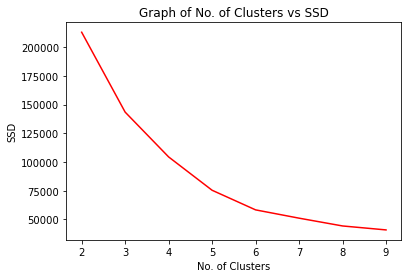

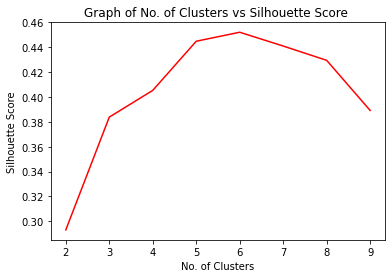

In [18]:
optimized_n_cluster_value(df1)

In [19]:
def svisualizer(x, ncluster,random_state=12601996):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    import numpy as np
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples 

    km = KMeans(n_clusters=ncluster, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=random_state)
    y_km = km.fit_predict(x)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0

    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    plt.show()	

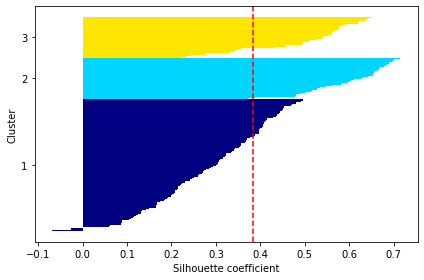

In [20]:
svisualizer(df1, 3)

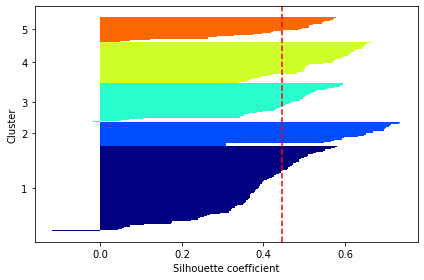

In [21]:
svisualizer(df1, 5)

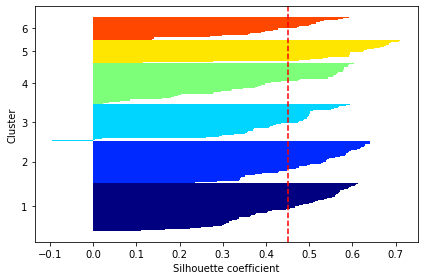

In [22]:
svisualizer(df1, 6)

In [23]:
def cluster_plot(data, nclusters, random_state=12601996):
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    X = data.copy()

    km = KMeans(n_clusters=nclusters, init='random', n_init=10,
                max_iter=300, tol=1e-04, random_state=random_state)
    y_km = km.fit_predict(X)

    # Visualize it:
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[
                :, 1], s=250, marker='*', c='red', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

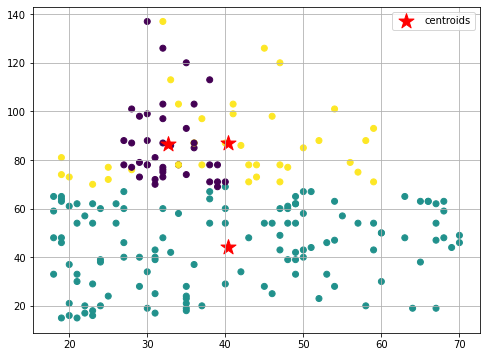

In [24]:
cluster_plot(df1,nclusters=3)

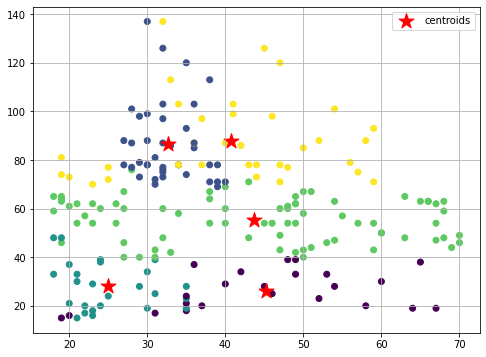

In [25]:
cluster_plot(df1,nclusters=5)

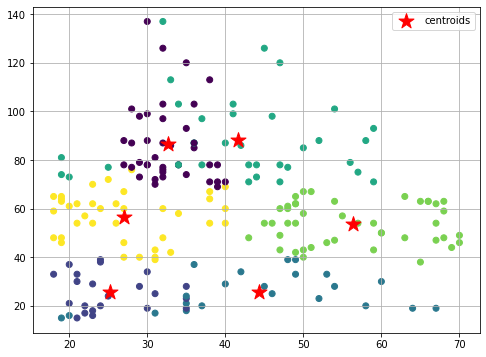

In [43]:
cluster_plot(df1,nclusters=6)

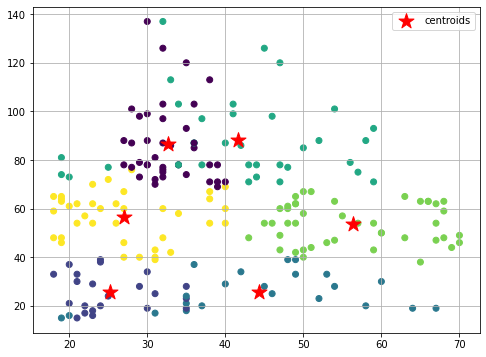

In [26]:
cluster_plot(df1,nclusters=6)

In [27]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=12601996)
y_km = km.fit_predict(df1)

In [28]:
df1['Clusters'] = y_km

In [44]:
df1

,Age,Annual Income (k$),Spending Score (1-100),Gender,Clusters
0,19,15,39,1.0,4
1,21,15,81,1.0,1
2,20,16,6,0.0,4
3,23,16,77,0.0,1
4,31,17,40,0.0,4
...,...,...,...,...,...
195,35,120,79,0.0,3
196,45,126,28,0.0,2
197,32,126,74,1.0,3
198,32,137,18,1.0,2


In [29]:
df1c1 = df1[df1['Clusters'] ==0]

In [30]:
df1c2 = df1[df1['Clusters'] ==1]

In [31]:
df1c3 = df1[df1['Clusters'] ==2]

In [32]:
df1c4 = df1[df1['Clusters'] ==3]

In [33]:
df1c5 = df1[df1['Clusters'] ==4]

In [34]:
max(df1c1['Spending Score (1-100)'])

61

In [35]:
max(df1c2['Spending Score (1-100)'])

99

In [36]:
max(df1c3['Spending Score (1-100)'])

39

In [37]:
max(df1c4['Spending Score (1-100)'])

97

In [38]:
max(df1c5['Spending Score (1-100)'])

40

In [39]:
df1c2['Spending Score (1-100)'].value_counts()

73    4
81    2
77    2
92    2
76    1
94    1
72    1
99    1
79    1
66    1
98    1
82    1
61    1
87    1
75    1
65    1
Name: Spending Score (1-100), dtype: int64

In [40]:
df1c4['Spending Score (1-100)'].value_counts()

75    4
88    3
91    2
97    2
69    2
86    2
83    2
74    2
90    2
93    2
73    2
95    2
87    1
72    1
77    1
76    1
89    1
78    1
63    1
92    1
71    1
68    1
85    1
79    1
Name: Spending Score (1-100), dtype: int64

In [41]:
df1c2

,Age,Annual Income (k$),Spending Score (1-100),Gender,Clusters
1,21,15,81,1.0,1
3,23,16,77,0.0,1
5,22,17,76,0.0,1
7,23,18,94,0.0,1
9,30,19,72,0.0,1
11,35,19,99,0.0,1
13,24,20,77,0.0,1
15,22,20,79,1.0,1
17,20,21,66,1.0,1
19,35,23,98,0.0,1


In [42]:
df1c4

,Age,Annual Income (k$),Spending Score (1-100),Gender,Clusters
123,39,69,91,1.0,3
125,31,70,77,0.0,3
127,40,71,95,1.0,3
129,38,71,75,1.0,3
131,39,71,75,1.0,3
133,31,72,71,0.0,3
135,29,73,88,0.0,3
137,32,73,73,1.0,3
139,35,74,72,0.0,3
141,32,75,93,1.0,3


**We should focus on the fourth cluster**

Customers who have a high spending score are between the ages 20–40. This tells us that the younger and the slightly older population are the ones which do the most shopping that's why they have a high spending score.
Customers with high annual income which is between 70(approx) to 140(k$) have the highest spending score between 60–100. This tells us that high annual income has a direct correlation with a greater spending score so the more you earn chances are you are going to spend more on shopping.

This marketing stratergy generally works well in the real world, as the higher your income and spending score, the higher chance of you making a bigger purchase resulting in higher sales.